# Tutorial for solving the Schrödinger equation in 1D using `expsolve.fourier`

This notebook introduces you to the basic functionalities of `expsolve.fourier` with the example of the Schrödinger equation in 1D. 

*&#169; Copyright 2019-2022 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [21]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt
import expsolve.fourier as fe

# Creating a 1D grid

The first step in solving a PDE using `expsolve.fourier` is to create a grid to discretise our initial functions. These are the grid points on which the numerical solution is computed.

A 1-dimensional grid over the spatial domain `[-1,1]` can be created with the `grid1d` function. 

```Python
    x = grid1d(n)
```
where `n` is the number of grid points.


In [22]:
x = fe.grid1d(10)
print(x)

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]


If a grid over a different spatial domain `xrange` is sought, we can use the following syntax:

```Python
    x = grid1d(n, xrange)
```
where `n` is the number of grid points and `xrange` is a list of two elements, e.g. `[a,b]` where `a` is the left boundary and `b` the right boundary of the periodic domain. 

Keep in mind that these periodic grids are symmetric and neither end point (`a` or `b`) is included among the grid points. This is in contrast to other periodic grids which may include the rightmost point (`b`) and exclude the leftmost point (`a`), for instance.

**NOTE:** The default value of `xrange` is `[-1,1]` in **all** functions in `expsolve.fourier`. Setting `xrange=-1` also forces the selection of the default range.

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


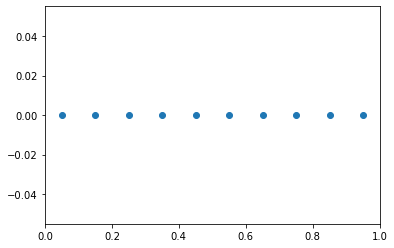

In [23]:
xrange = [0, 1]
x = fe.grid1d(10, xrange)
print(x)
plt.scatter(x, np.zeros(x.shape))
plt.xlim(xrange[0],xrange[1])
plt.show()

# Differentiation

`evolve.fourier` implements a differentiation operator `diffop` which utilises Fast Fourier Transform (FFT) for differentiation. The syntax for differentiation of a function in 1D is:

```Python
    df = fe.diffop(0,1,f,xrange)
    d2f = fe.diffop(0,2,f,xrange)
```

Here `f` is a vector with values of a function $f$ on a grid. Then `df` is the `1`st derivative of $f$ in the `0`th direction (i.e. the first and the only coordinate). We also have to specify the `xrange` of the grid on which $f$ is discretised - this is as before, and the default value of `xrange` is `[-1,1]`.

The $k$ th derivative is obtained as `fe.diffop(0,k,f,xrange)`. In `examples/fourier/tutorial2d.ipynb` you will see how to differentiate a `2d` function in either direction ($x$ or $y$).

NOTE: `evolve.fourier` assumes that `f` is complex-valued, and so the derivative produced by `diffop` (`df`) is also complex-valued. If the function `f` is real-valued, the result of `diffop` may still have non-zero imaginary component. In such a case, it is sensible to only take the `real` part of the computed derivative. See the following:

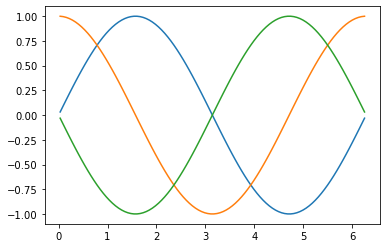

In [24]:
xrange = [0, 2*np.pi]
n = 100
x = fe.grid1d(n, xrange)
s = np.sin(x)
ds = np.real(fe.diffop(0,1,s,xrange))  
d2s = np.real(fe.diffop(0,2,s,xrange))  

plt.plot(x, s)
plt.plot(x, ds)
plt.plot(x, d2s)
plt.show()

Let's see how accurate the derivative computed in this way is. The true derivative of $\sin(x)$ is $\cos(x)$. 

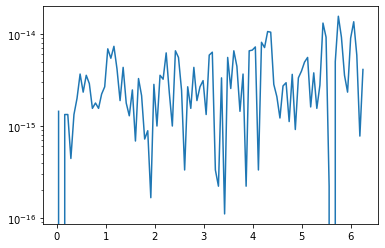

In [25]:
c = np.cos(x)
plt.semilogy(x, np.abs(c-ds))
plt.show()

This shows us that the derivative computed in this way is extremely accurate. $\sin$ is a very simple function, of course. 

A more complicated example of a **periodic** function is $\exp(\sin(x))$ whose derivative is $\cos(x) \exp(\sin(x))$.

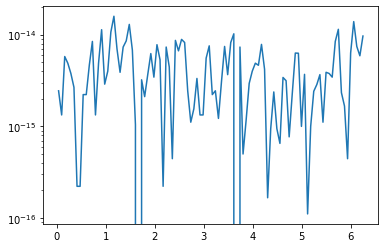

In [26]:
f = np.exp(np.sin(x))
df_true = np.cos(x)*np.exp(np.sin(x))
df_numerical = np.real(fe.diffop(0,1,f,xrange))

plt.semilogy(x, np.abs(df_true-df_numerical))
plt.show()

Again, the computation looks accurate up to $14$ digits of precision!

## A shorter example with the default `xrange` `[-1,1]`

**NOTE**: differentiation in `evolve.fourier` is ONLY accurate for smooth periodic functions!

Let's see with an example:

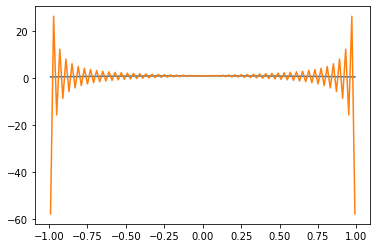

In [27]:
x = fe.grid1d(100)

s = np.sin(x)
ds_true = np.cos(x)
ds_numerical = np.real(fe.diffop(0, 1, s))

plt.plot(x, ds_true)
plt.plot(x, ds_numerical)
plt.show()

The computed derivative is extremely inaccurate since $sin$ is not periodic over $[-1,1]$ (note that we didn't specify `xrange` here, and so it defaults to `[-1,1]`).

Let's contrast this with a function that's periodic on $[-1,1]$:

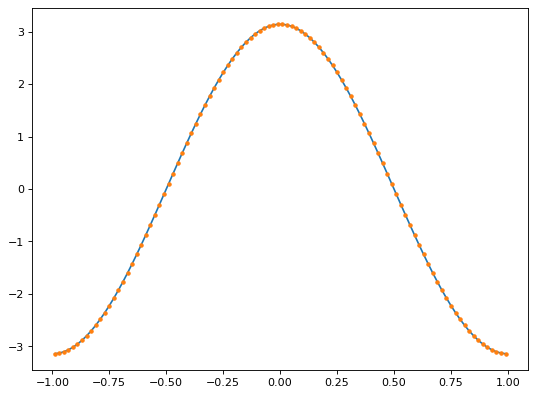

In [8]:
spi = np.sin(np.pi*x)
dspi_true = np.pi*np.cos(np.pi*x)
dspi_numerical = np.real(fe.diffop(0, 1, spi))

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(x, dspi_true)
plt.plot(x, dspi_numerical, marker='.', linestyle=' ')
plt.show()

## Differentiation Matrix

The differentation operator `diffop` is a function that differentiates a function `u`. This is a linear differentiation operator $D(u)$ which is a linear transformation, i.e. $D( a u + b v) = a D(u) + b D(v)$. All linear transformations have a matrix representation, and thus we must have a *matrix* $\mathbf{D}$ such that 

$$ D(u) = \mathbf{D} u$$

The way the differentiation operator `diffop` (i.e. $D$) is implemented, it uses FFT and thus costs $\mathcal{O}\left(n \log n\right)$, which is much more efficient than creating and storing the $n \times n$ matrix $\mathbf{D}$ and computing the matrix-vector product $\mathbf{D} u$, which costs $\mathcal{O}\left(n^2 \right)$.

However, sometimes we might want access to differentiation matrices such as $\mathbf{D}$. `fourier.evolve` provides the `diffmatrix` function with the following syntax for this purpose:

```Python
    D = fe.diffmatrix(1, n, xrange)
    ds = D.dot(s)
```
where `D` is the first differentiation matrix (i.e. for computing the first derivative), `n` is the size of the matrix ($n \times n$) and `xrange` is as before. When this matrix is multiplied with a vector `s` discretised on a grid on `xrange` with `n` points, it produces the derivative of `s`. 

* As before, if `s` is a real valued function, it is sensible to take the real component of `D.dot(s)`. 
* As always, the default value of `xrange` is `[-1,1]`.

Here is an example of computing the second derivative by multiplying with the second differentation matrix:

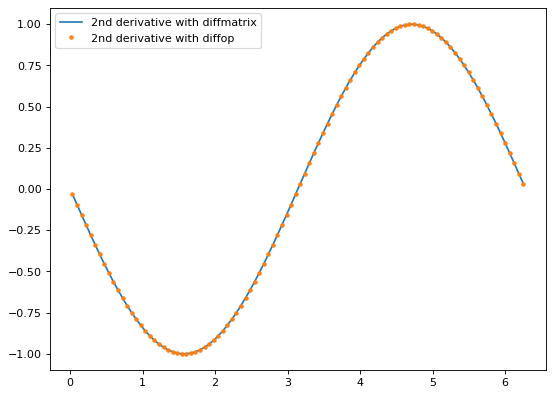

In [48]:
xrange = [0, 2*np.pi]
n = 100
x = fe.grid1d(n, xrange)
s = np.sin(x)

D2 = fe.diffmatrix(2, n, xrange)
D2s = np.real(D2.dot(s))
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(x, D2s)
plt.plot(x, d2s,marker='.',linestyle=' ')
plt.legend(['2nd derivative with diffmatrix', '2nd derivative with diffop'])
plt.show()

Let's see what the difference between the differentiation matrix and the differentiation operator is.

In [49]:
print(np.max(np.abs(D2.dot(s)-d2s)))

1.5274846339287777e-12


# Solving the Schrödinger equation

The linear time-dependent Schrödinger equation in 1D with periodic boundaries over a domain $[-L,L]$ can be written as

$$ i \partial_t \psi(x,t) = \mathrm{H} \psi(x,t), \qquad x \in [-L,L] $$

where $\mathrm{H}$ is the Hamiltonian operator

$$ \mathrm{H} = -\partial_x^2 + V(x) $$

and $V(x)$ is a (typically real-valued) potential function. Typically, we spatially discretise the PDE, replacing the Hamiltonian operator $\mathrm{H}$ with a discretised Hamiltonian matrix $\mathbf{H}$, and arriving at the system of ODEs:

$$ i \partial_t u(t) = \mathbf{H} u(t), $$

where $u(t)$ is now a vector of values on the spatial grid, and the discretised Hamiltonian matrix is

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

The exact solution of this system of ODEs is given by the matrix exponential:

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

## An example using a brute force approach

The brute force approach for solving the Schrödinger equation consists of directly computing the matrix exponential. We can do this using the matrix exponentiation function `expm` in `scipy`.

### Grid

In [50]:
n = 200
L = 10
xr = [-L, L]
x = fe.grid1d(n, xr)

### Initial Condition

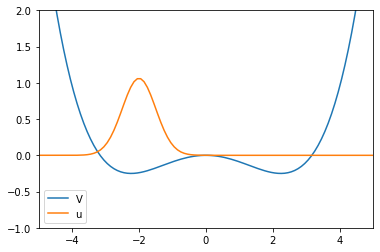

In [51]:
x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))

u = u/fe.l2norm(u, xr)

V = x**4 - 10*x**2

plt.plot(x, V/100)
plt.plot(x, u)
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### The `l2norm` function


We scale the potential down, so that we can see it together with the initial condition `u`. Note that the wavefunction in Quantum Mechanics should be normalised. We do this in the code

```Python
    u = u/fe.l2norm(u, xrange)
```

The function `l2norm` is the `evolve.fourier` equivalent of the `norm` function in `numpy.linalg`. Unlike the `numpy` function which computes the $\ell^2$ norm, however, the function `l2norm` computes an approximation to the $L^2$ norm (by scaling the $\ell^2$ norm with the grid resolution appropriately). For instance, if we discretise a function on finer grid, `numpy.linalg.norm` will change substantially, while `l2norm` will just become a more accurate approximation of the $L^2$ norm. Let's see this with an example:

In [52]:
f1 = np.sin(fe.grid1d(n, xr))
f2 = np.sin(fe.grid1d(2*n, xr))
print(f'The numpy norm of sin changes from {np.linalg.norm(f1)} to {np.linalg.norm(f2)} when we consider a finer grid')
print(f'The l2norm of sin does not change much: going from {fe.l2norm(f1, xr)} to {fe.l2norm(f2, xr)} when we consider a finer grid')

The numpy norm of sin changes from 9.768708050916835 to 13.815453030733535 when we consider a finer grid
The l2norm of sin does not change much: going from 3.08913672381213 to 3.0892292116675675 when we consider a finer grid


The syntax of `l2norm` is

```Python
    l2norm(u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`. 

* The output of `l2norm` is always real and non-negative.
* As always, if `xrange` is not provided, a default range of `[-1,1]` is assumed.

### The `l2inner` function

Similarly, `evolve.fourier` provides the `l2inner` function for computing the inner product. This is similar to the `.dot` functionality in Python which implements the $\ell^2$ inner product, except the `l2inner` function implements the $L^2$ inner product. Once again, this appropriately takes the discretisation into account. 

In [53]:
f1 = np.sin(fe.grid1d(n, xr))
g1 = np.exp(np.sin(fe.grid1d(n, xr)))

f2 = np.sin(fe.grid1d(2*n, xr))
g2 = np.exp(np.sin(fe.grid1d(2*n, xr)))
print(f'The Python inner product of sin(x) and exp(sin(x)) changes from {f1.dot(g1)} to {f2.dot(g2)} when we consider a finer grid')
print(f'The l2inner of sin(x) and exp(sin(x)) does not change much: going from {fe.l2inner(f1, g1, xr)} to {fe.l2inner(f2, g2, xr)} when we consider a finer grid')

The Python inner product of sin(x) and exp(sin(x)) changes from 107.74533373906141 to 215.50324492213656 when we consider a finer grid
The l2inner of sin(x) and exp(sin(x)) does not change much: going from 10.774533373906142 to 10.775162246106829 when we consider a finer grid


The syntax of `l2inner` is

```Python
    l2inner(u, v, xrange)
```
where `u` and `v` are the vector of values on a periodic grid defined on the domain `xrange`. 

* In general, `l2inner` produces a complex-valued result since it represents a complex inner product. If a real value is expected, this should be explicitly extracted.
* As always, if `xrange` is not provided, a default range of `[-1,1]` is assumed.

### Brute force solution using `expm`

First we create the Hamiltonian matrix: 

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

In [54]:
D2 = fe.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)

Now we can compute the matrix exponential $\exp\left(-i t \mathbf{H}\right)$ using `scipy`s `expm` function and compute the solution as

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

In [55]:
T = 1.0
uT = expm(-1j*T*H).dot(u)

Let's plot the solution at $T=1$:

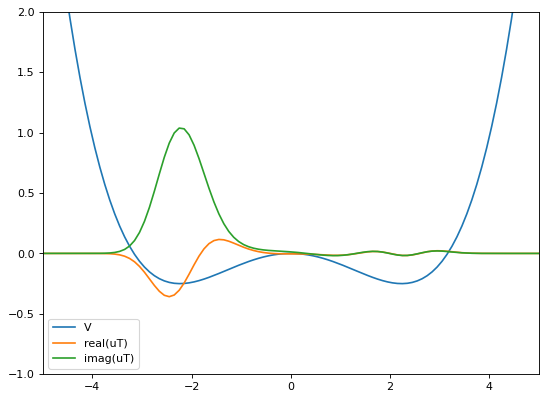

In [56]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(x, V/100)
plt.plot(x, np.real(uT))
plt.plot(x, np.imag(uT))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','real(uT)','imag(uT)'])
plt.show()

### Conserved quantities

The true solution of the Schrödinger equation conserves many properties. A few of them are:

$$ \|u(t)\|_{L^2} = \|u(0)\|_{L^2}$$

$$ \langle u(t) , \mathrm{H} u(t) \rangle = \langle u(0) , \mathrm{H} u(0) \rangle$$

i.e. 

* The $L^2$ norm of the solution is conserved (and is $=1$ if we start with normalised initial condition). This property is crucial since the amplitude $|u(x,t)|^2$ defines a probability density function and must integrate to $1$ (i.e. overall probability of finding a particle somewhere should be $1$).

* The energy (i.e. $\langle u(t) , \mathrm{H} u(t) \rangle$) is conserved.

Let's see if our numerical solution using `expm` conserves these quantities:

In [57]:
print(f'L2 norm of initial condition was {fe.l2norm(u, xr)}')
print(f'L2 norm of expm solution at T is {fe.l2norm(uT, xr)}')
print(f'Change in L2 norm is {fe.l2norm(uT, xr) - fe.l2norm(u, xr)}')

L2 norm of initial condition was 1.0
L2 norm of expm solution at T is 1.0000000000000826
Change in L2 norm is 8.260059303211165e-14


In [58]:
E0 = np.real(fe.l2inner(u, H.dot(u)))
ET = np.real(fe.l2inner(uT, H.dot(uT)))

print(f'Energy of initial condition was {E0}')
print(f'Energy of expm solution at T is {ET}')
print(f'Change in Energy is {ET-E0}')

Energy of initial condition was -2.020312500000004
Energy of expm solution at T is -2.020312500000327
Change in Energy is -3.228528555609955e-13


We see that the numerical solution obtained with `expm` conserves the $L^2$ norm and energy up to machine precision.

### Other observables

The inner product

$$ \mathbb{E}_u[O] := \langle O \rangle_u := \langle u, O u \rangle $$

defines the expected value of the *observable* $O$ when the state of the quantum system is given by the wavefunction $u$. An observable is a Hermitian matrix (or operator) and the expected value of the observable is always real. 

The energy we computed above is the expected value of the Hamiltonian $\mathrm{H}$, and the $L^2$ norm is the expected value of the identity observable $O=I$. 

Some other observables of interest are:

* $O=x$. This gives us the position of the particle.
* $O=-i \partial_x$. This gives us the momentum of the particle.
* $O=-\partial_x^2$. This gives us the kinectic energy of the particle.
* $O=V(x)$. This gives us the potential energy of the particle.

All these quantities are the expected or mean values.

Observables are implemented using the `observable` function, the syntax of which is:

```Python
    fe.observable(O, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `O` is a Hermitian operator or matrix. Let us see this with examples where we create named observables as `lambda` functions:

In [59]:
D1 = fe.diffmatrix(1, n, xr)

energy = lambda f: fe.observable(H, f, xr)
position = lambda f: fe.observable(np.diag(x), f, xr)
momentum = lambda f: fe.observable(1j*D1, f, xr)
kinetic = lambda f: fe.observable(D2, f, xr)
potential = lambda f: fe.observable(np.diag(V), f, xr)

In [60]:
print(f'Energy changes from {energy(u)} to {energy(uT)}')
print(f'Mean position changes from {position(u)} to {position(uT)}')
print(f'Momentum changes from {momentum(u)} to {momentum(uT)}')
print(f'Kinectic energy changes from {kinetic(u)} to {kinetic(uT)}')
print(f'Potential energy changes from {potential(u)} to {potential(uT)}')

Energy changes from -20.203125000000043 to -20.20312500000327
Mean position changes from -2.0 to -2.1984772640061894
Momentum changes from 4.06695781550602e-16 to 0.5490626188561928
Kinectic energy changes from -1.999999999999956 to -2.4720748165191617
Potential energy changes from -22.203125 to -22.675199816522426


Note that even though total energy is conserved, Kinectic and Potential energy are not conserved (no different from the case of a pendulum, of course). 

Momentum is nearly 0, but becomes 0.55 at $T=1$.

## The splitting approach for solving the Schrödinger equation

The splitting approach is to approximate the matrix exponential in 

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0) $$

as 

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i h\, \texttt{diag}(V) \right) $$

which is the 1st order approximation called the Trotter splitting (and h is the time step) or as

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) $$

which is the 2nd order approximation called the Strang splitting.

The overall numerical scheme (in the case of the Strang splitting) is:

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

Splitting is useful because we can compute the exponentials of $\texttt{diag}(V)$ and $\mathbf{D}_2$ much more cheaply separately than we can compute the exponential when they are combined in the full discrestised $\mathbf{H}$. For instance, the computation of the exponential of $\mathbf{H}$ using `expm` costs $\mathcal{O}\left(n^3\right)$ operations. On the other hand, expoential of $\texttt{diag}(V)$ can be computed in a pointwise way in $\mathcal{O}(n)$ operations, while exponential of $\mathbf{D}_2$ costs us $\mathcal{O}(n \log n)$ operations. The latter is because the Fourier differentiation matrices in `evolve.fourier` can be diagonalised with the Fourier transform:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). 

In `evolve.fourier`, the function `diffop` computes the action of `\mathbf{D}_k` on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preferred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

With the help of Taylor expanion, we can also seee that exponential of $\mathbf{D}_k$ is

$$ \exp(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ \exp(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} u = \texttt{ifft}\left( \exp(c s_k) \texttt{fft}(u) \right) .$$

This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDu = fe.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c D_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $D_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* Since we are working in 1D here, $j=0$. 
* Since we need 2nd derivative, $k=2$. 

### Grid & Initial Condition

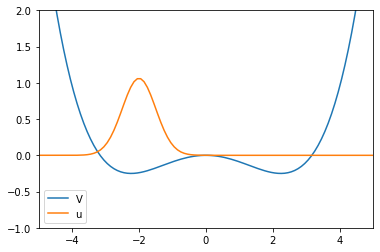

In [61]:
n = 200
L = 10
xr = [-L, L]
x = fe.grid1d(n, xr)

x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))

u = u/fe.l2norm(u, xr)

V = x**4 - 10*x**2

plt.plot(x, V/100)
plt.plot(x, u)
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### A single step of Strang

We create lambda functions for computing $\exp(i h D_2) u$ and $\exp(-i h \texttt{diag}(V)) u$, and compose them to form a single step of Strang:

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

In [62]:
eLu = lambda h, u: fe.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: np.exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

Let's run a single step of Strang for time step $h=0.1$ and compare it to the `expm` solution (which is exact to machine precision):

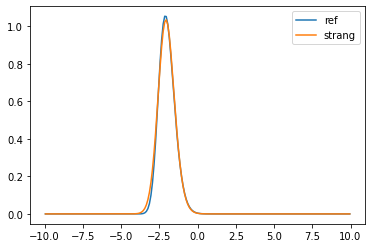

The L2 error in Strang splitting is 0.06299478338254459


In [63]:
D2 = fe.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)
exact = lambda h, u: expm(-1j*h*H).dot(u)

h = 0.1

uref = exact(h, u)
ustrang = strang(h, u)

plt.plot(x, np.abs(uref))
plt.plot(x, np.abs(ustrang))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {fe.l2norm(uref-ustrang, xr)}')

### Full run of Strang up to time T = 1

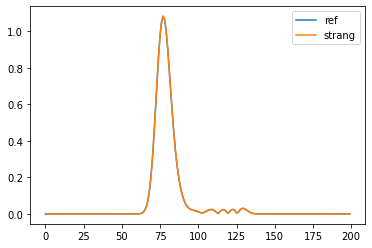

The L2 error in Strang splitting is 1.6602442225872818e-05


In [64]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

urefT = exact(T, u)
ustrangT = runstrang(T,1000,u)
plt.plot(np.abs(urefT))
plt.plot(np.abs(ustrangT))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {fe.l2norm(urefT-ustrangT, xr)}')

When we run Strang splitting with a small enough time step, it becomes pretty accurate

### Analysing order of Strang

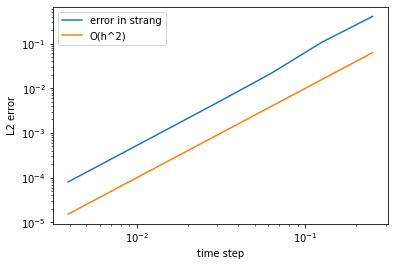

In [65]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [fe.l2norm(urefT-runstrang(T,N,u)) for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.

### A comparison of speed

When $n$ becomes large, `expm` is an extremely inefficient method since its cost scales as $\mathcal{O}\left(n^3\right)$. On the other hand, the cost of Strang scales as $\mathcal{O}\left(n \log n\right)$, which is significantly cheaper

In [66]:
import time

n = 2000

L = 10
xr = [-L, L]
x = fe.grid1d(n, xr)

x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))
u = u/fe.l2norm(u, xr)

V = x**4 - 10*x**2

T = 1

tic_exact = time.perf_counter()
D2 = fe.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)
urefT = expm(-1j*T*H).dot(u)
toc_exact = time.perf_counter()
print(f'expm took {toc_exact-tic_exact:0.4f} seconds')

tic_strang = time.perf_counter()
eLu = lambda h, u: fe.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: np.exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

ustrangT = runstrang(T, 1000, u)
toc_strang = time.perf_counter()


print(f'Strang took {toc_strang-tic_strang:0.4f} seconds')

print(f'The L2 error in Strang splitting is {fe.l2norm(urefT-ustrangT, xr)}')

expm took 13.3084 seconds
Strang took 0.5694 seconds
The L2 error in Strang splitting is 1.6602440303696865e-05


We achieve pretty reasonable accuracy at a much lower cost when using Strang splitting.

### Observables again

Recall that observables are implemented using the `observable` function, the syntax of which is:

```Python
    fe.observable(O, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `O` is a Hermitian operator or matrix. In the first instance, we used `O` as Hermitian matrices. However, this is not fully efficient. For example passing the $n \times n$ Hamiltonian matrix will involve a cost of $\mathcal{O}\left(n^2\right)$ in the computation of the observable. Instead, if we use the operator form, the cost is $\mathcal{O}\left(n \log n\right)$ due to the use of FFTs. Let's see this with examples:

We create the Hamiltonian operator as a lambda function:

In [67]:
Hop = lambda psi: -fe.diffop(0, 2, psi, xr) + V*psi

Then, the energy observable can be defined as:

In [68]:
energy = lambda f: fe.observable(Hop, f, xr)

i.e. we use Hop instead of H! 

Similarly, we create other operators. For instance, the position operator is multiplication by $x$ which is achieved as `lambda psi: x*psi` and the momentum operator is multiplication by $-i$ and 1st derivative operation. Let us put these in a dictionary:

In [69]:
obs = {'energy': Hop, 
'position': lambda psi: x*psi,
'momentum': lambda psi: 1j*fe.diffop(0, 1, psi, xr),
'kinetic': lambda psi: -fe.diffop(0, 2, psi, xr),
'potential':lambda psi: V*psi}

We will store the values of observables in the dictionary `obsvalues`. Let us set all values to `[]`

In [70]:
obsvalues = {}
for o in obs:
    obsvalues[o]=[]

def compute_obs_values(u):
    for o in obs:
        op = obs[o]
        obsvalues[o].append(fe.observable(op, u, xr))

In [71]:
n = 100
L = 10
xr = [-L, L]
x = fe.grid1d(n, xr)

x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))
u = u/fe.l2norm(u, xr)

V = x**4 - 10*x**2

T = 1

compute_obs_values(u)


eLu = lambda h, u: fe.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: np.exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
        compute_obs_values(u)
    return u

ustrangT = runstrang(T, 1000, u)

In [72]:
time_grid = np.arange(1000+1)/1000

Total energy does change now! Strang does not conserve energy exactly.

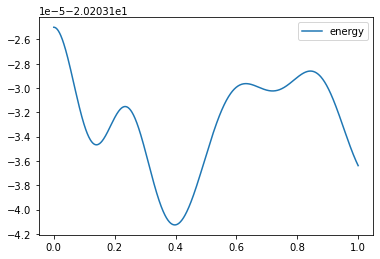

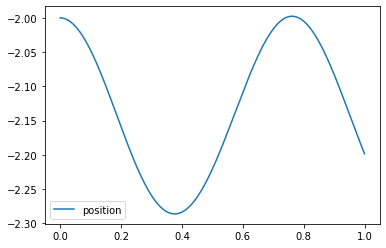

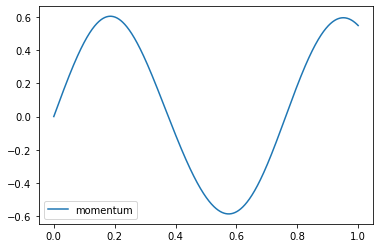

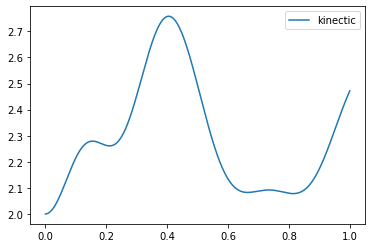

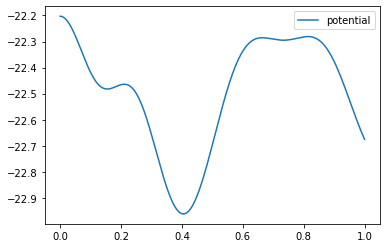

In [73]:
for o in obs:
    ov = obsvalues[o]
    plt.figure()
    plt.plot(time_grid, ov)   
    plt.legend([o])
    plt.show()

### No need for `lambda`

Of course, there is no need to use `lambda` functions `eVu`, `eLu` and `strang`. We can directly compute the actions of `exp(V)` and `exp(D2)` in the loop of `runstrang`.

In [36]:
obsvalues = {}
for x in obs:
    obsvalues[x]=[]

n = 100
L = 10
xr = [-L, L]
x = fe.grid1d(n, xr)

x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))
u = u/fe.l2norm(u, xr)

V = x**4 - 10*x**2

T = 1

compute_obs_values(u)

def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = np.exp(-1j*(h/2)*V)*u
        u = fe.diffopexp(0, 2, 1j*h, u, xr)
        u = np.exp(-1j*(h/2)*V)*u
        compute_obs_values(u)
    return u

ustrangT = runstrang(T, 1000, u)